In [141]:
import d6tflow
import luigi
from luigi.util import inherits
import sklearn, sklearn.datasets, sklearn.svm, sklearn.linear_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mape
from theano import shared

### Helper Functions

In [142]:
def plot_forecast(taskModel,title):
    posterior_mean = taskModel.output()['posterior_mean'].load()
    upper_bound = taskModel.output()['upper_bound'].load()
    lower_bound = taskModel.output()['lower_bound'].load()
    MAPE = taskModel.output()['MAPE'].load()
    test = TaskPreprocess().output()['test'].load()
    test_Y = test['y'].values
   
    fig, ax = plt.subplots(figsize=(15,3))
    ax.set_title (title)
    ax.plot(posterior_mean,label='posterior mean')
    ax.plot(test_Y,label='actual')
    ax.plot(upper_bound,label='upper bound 95%',color='green',linestyle='--')
    ax.plot(lower_bound,label='lower bound 5%',color='red', linestyle='--')

    ax.set_xlabel('Data Points')
    ax.fill_between(np.arange(len(test)), lower_bound, upper_bound,facecolor='red', alpha=0.05)
    ax.set_ylabel('Value')
    ax.set_xticks(np.arange(len(test)))
    ax.legend()
    plt.show()
    plt.savefig('reports_plot.png')
    
    
def accuracy(taskModel):
    return 'MAPE: {}%'.format(taskModel.output()['MAPE'].load())

In [158]:
# define workflow
class TaskGetData(d6tflow.tasks.TaskPqPandas):  # save dataframe as parquet
    persist=['fred_df', 'credit_card_df']
    def run(self):
        fred_df = pd.read_parquet('fred_df.parquet', engine='pyarrow')
        credit_card_df = pd.read_parquet('credit_card_df.parquet', engine='pyarrow')
       
        self.save({'fred_df':fred_df, 'credit_card_df':credit_card_df}) # quickly save dataframe
        
@d6tflow.requires(TaskGetData) # define dependency
class TaskPreprocess(d6tflow.tasks.TaskPqPandas):
    do_preprocess = luigi.BoolParameter(default=True) # parameter for preprocessing yes/no
    persist=['train','test']
    def run(self):
        fred_df = self.input()['fred_df'].load() # quickly load required data
        credit_card_df = self.input()['credit_card_df'].load()
        
        if self.do_preprocess:
            fred_df_us_retail_advanced = fred_df[fred_df['type'] == 'us_retail_advanced'].reset_index()
            fred_df_us_retail_advanced['date'] = fred_df_us_retail_advanced['date'].dt.to_period('M')
            credit_card_df['optimized_date'] = pd.to_datetime(credit_card_df['optimized_date'])
            credit_card_df_simple=credit_card_df[['optimized_date','state','panel_sales','yoy_trailing_four_week_sales']]
            credit_card_df_simple=credit_card_df_simple.groupby(['optimized_date']).mean()    
            credit_card_df_simple['optimized_date']=credit_card_df_simple.index
            credit_card_df_simple['month_year'] = credit_card_df_simple['optimized_date'].dt.to_period('M')
            credit_card_df_temp=credit_card_df_simple[['month_year','optimized_date','yoy_trailing_four_week_sales']]
            credit_card_df_simple=credit_card_df_simple[['month_year','panel_sales']]
            credit_card_df_simple=credit_card_df_simple.groupby(['month_year']).mean()
            credit_card_df_temp=credit_card_df_temp.groupby(['month_year']).last()
            credit_card_df_simple = credit_card_df_simple.join(credit_card_df_temp)
            df_train = fred_df_us_retail_advanced.set_index('date').join(credit_card_df_simple)
            
            df_train = pd.DataFrame.dropna(df_train).reset_index()
            df_train['y'] = df_train.value
            df_train['Qtr'] = df_train.date.dt.quarter-1
            drop_columns = ['index','type','value','optimized_date','date']
            df_train = df_train.drop(drop_columns,axis=1)
            df_train.iloc[:,:-1] = sklearn.preprocessing.scale(df_train.iloc[:,:-1])  # standardise to unit scale.

            test_start  = int(len(df_train) * 0.7) # train test split
            train = df_train[:test_start]
            test = df_train[test_start:]
        self.save({'train':train, 'test':test})

@d6tflow.requires(TaskPreprocess) # automatically pass parameters upstream
class TaskTrain_Evaluate(d6tflow.tasks.TaskPickle): # save output as pickle
    model = luigi.Parameter(default='model_naive') # parameter for model selection
    persist=['posterior_mean', 'upper_bound','lower_bound', 'MAPE']
    
    def run(self):
        train = self.input()['train'].load()
        test = self.input()['test'].load()
        drop_col = ['y']
        train_X = train.drop(drop_col,axis=1)
        train_Y = train['y'].values
        test_X = test.drop(drop_col,axis=1)
        test_Y = test['y'].values
        # set shared predictor
        predictor_1 = np.asarray(train_X['panel_sales'])        
        predictor_2 = np.asarray(train_X['yoy_trailing_four_week_sales'])   
        obs_data = train_Y
        
        if self.model=='model_naive':
            with pm.Model() as model_naive:
                std = pm.Exponential("std", 1.0)

                beta_0 = pm.Normal("beta_0", mu=0, sd=0.5)
                beta_1 = pm.Normal("beta_1", mu=0, sd=1)

                # As data is on unit scale.
                pred_1 = pm.Data("pred_1", predictor_1)
                
                # Specify a linear model
                mean = pm.Deterministic("mean", beta_0  + beta_1 * pred_1)
                obs = pm.Normal("obs", mu=mean, sd=std, observed=obs_data)

                with model_naive:
                    trace = pm.sample(2000,tune=1000, cores=2)

                predictors_1_out_of_sample = np.asarray(test_X['panel_sales'])
                
                with model_naive:
                    # update values of predictors:
                    pm.set_data({"pred_1": predictors_1_out_of_sample})
                    # use the updated values and predict outcomes and probabilities:
                    pp_trace = pm.sample_posterior_predictive(trace,samples=2000)

                obs_simulations = pp_trace['obs']
                obs_simulations_reshape = obs_simulations.T
                upper_bound = np.quantile(obs_simulations_reshape, 0.95, axis=1)
                lower_bound = np.quantile(obs_simulations_reshape, 0.05, axis=1)
                posterior_mean = pp_trace['obs'].mean(axis=0)
                MAPE = mape(test_Y,posterior_mean).round(2)

        elif self.model=='model_add_regressor':

            with pm.Model() as model_add_regressor:
                std = pm.HalfCauchy("sd", 2.0)

                betas = pm.Normal("betas", mu=0.0, sd=np.array([0.5, 1.0, 1.0]), shape=3)

                # set predictors as shared variable to change them for PPCs:
                pred_1 = pm.Data("pred_1", predictor_1)
                pred_2 = pm.Data("pred_2", predictor_2)

                mean = pm.Deterministic("mean", betas[0] + betas[1] * pred_1 + betas[2] * pred_2)

                obs = pm.Normal("obs", mu=mean, sd=std, observed=obs_data)

                with model_add_regressor:
                    trace = pm.sample(2000,tune=1000, cores=2)

                predictors_1_out_of_sample = np.asarray(test_X['panel_sales'])
                predictors_2_out_of_sample = np.asarray(test_X['yoy_trailing_four_week_sales'])
                
                with model_add_regressor:
                    # update values of predictors:
                    pm.set_data({"pred_1": predictors_1_out_of_sample})
                    pm.set_data({"pred_2": predictors_2_out_of_sample})
                    # use the updated values and predict outcomes and probabilities:
                    pp_trace = pm.sample_posterior_predictive(trace,samples=2000)

                obs_simulations = pp_trace['obs']
                obs_simulations_reshape = obs_simulations.T
                upper_bound = np.quantile(obs_simulations_reshape, 0.95, axis=1)
                lower_bound = np.quantile(obs_simulations_reshape, 0.05, axis=1)
                posterior_mean = pp_trace['obs'].mean(axis=0)
                MAPE = mape(test_Y,posterior_mean).round(2)
        elif self.model=='model_Hierarchical':
            N_group=4
            # set shared predictor
            obs_data = train_Y
            quarter_index = train_X.Qtr.values

            with pm.Model() as model_Hierarchical:
                #Hyperpriors
                mu_0 = pm.Normal('mu_0', mu=0, sd=2)
                sd_0 = pm.Exponential("sd_0", lam=1.0)
                mu_1 = pm.Normal('mu_1', mu=0, sd=2)
                sd_1 = pm.Exponential("sd_1", lam=1.0)
                std = pm.Exponential("std", lam=1.0)
                # parameters for each quarter group, distributed around group.
                beta_0 = pm.Normal("beta_0", mu=mu_0, sd=sd_0, shape=N_group)
                beta_1 = pm.Normal("beta_1", mu=mu_1, sd=sd_1, shape=N_group)

                pred_1 = pm.Data("pred_1", predictor_1)
                quar_index = pm.Data("quarter_index_shared", quarter_index)

                mean = pm.Deterministic("mean", beta_0[quar_index] + beta_1[quar_index] * pred_1)

                obs = pm.Normal("obs", mu=mean, sd=std, observed=obs_data)

                with model_Hierarchical:
                    trace_Hierarchical = pm.sample(2000,tune=5000, cores=2)

                predictors_1_out_of_sample = np.asarray(test_X['panel_sales'])
                quarter_index_out_of_sample = np.asarray(test_X['Qtr'])

                outcomes_out_of_sample = test['y'].values
                with model_Hierarchical:
                    # update values of predictors:
                    pm.set_data({"pred_1": predictors_1_out_of_sample})
                    pm.set_data({"quarter_index_shared": quarter_index_out_of_sample})
                    # use the updated values and predict outcomes and probabilities:
                    pp_trace = pm.sample_posterior_predictive(trace_Hierarchical,samples=2000)

                obs_simulations = pp_trace['obs']
                obs_simulations_reshape = obs_simulations.T
                upper_bound = np.quantile(obs_simulations_reshape, 0.95, axis=1)
                lower_bound = np.quantile(obs_simulations_reshape, 0.05, axis=1)
                posterior_mean = pp_trace['obs'].mean(axis=0)
                MAPE = mape(test_Y,posterior_mean).round(2)
        else:
            raise ValueError('invalid model selection')
        
        self.save({'posterior_mean':posterior_mean, 'upper_bound':upper_bound,'lower_bound':lower_bound, 'MAPE':MAPE})

d6tflow.preview(TaskTrain_Evaluate())


└─--[TaskTrain_Evaluate-{'do_preprocess': 'True', 'model': 'model_naive'} (PENDING)]
   └─--[TaskPreprocess-{'do_preprocess': 'True'} (COMPLETE)]
      └─--[TaskGetData-{} (COMPLETE)]


In [159]:
taskModel1=TaskTrain_Evaluate()
taskModel2=TaskTrain_Evaluate(model='model_add_regressor')
taskModel3=TaskTrain_Evaluate(model='model_Hierarchical')
d6tflow.run(taskModel1)
d6tflow.run(taskModel2)
d6tflow.run(taskModel3)

INFO: Informed scheduler that task   TaskTrain_Evaluate_True_model_naive_2e0d4d5183   has status   PENDING
INFO: Informed scheduler that task   TaskPreprocess_True_e00389f8b2   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
INFO: [pid 25615] Worker Worker(salt=641365787, workers=1, host=us-retail-sales-forecast, username=jupyter, pid=25615) running   TaskTrain_Evaluate(do_preprocess=True, model=model_naive)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_1, beta_0, std]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


INFO: [pid 25615] Worker Worker(salt=641365787, workers=1, host=us-retail-sales-forecast, username=jupyter, pid=25615) done      TaskTrain_Evaluate(do_preprocess=True, model=model_naive)
INFO: Informed scheduler that task   TaskTrain_Evaluate_True_model_naive_2e0d4d5183   has status   DONE
INFO: Worker Worker(salt=641365787, workers=1, host=us-retail-sales-forecast, username=jupyter, pid=25615) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 1 complete ones were encountered:
    - 1 TaskPreprocess(do_preprocess=True)
* 1 ran successfully:
    - 1 TaskTrain_Evaluate(do_preprocess=True, model=model_naive)

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====

INFO: Informed scheduler that task   TaskTrain_Evaluate_True_model_add_regres_e0af7fc42a   has status   PENDING
INFO: Informed scheduler that task   TaskPreprocess_True_e00389f8b2   has status   DO

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


INFO: [pid 25615] Worker Worker(salt=541212972, workers=1, host=us-retail-sales-forecast, username=jupyter, pid=25615) done      TaskTrain_Evaluate(do_preprocess=True, model=model_add_regressor)
INFO: Informed scheduler that task   TaskTrain_Evaluate_True_model_add_regres_e0af7fc42a   has status   DONE
INFO: Worker Worker(salt=541212972, workers=1, host=us-retail-sales-forecast, username=jupyter, pid=25615) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 1 complete ones were encountered:
    - 1 TaskPreprocess(do_preprocess=True)
* 1 ran successfully:
    - 1 TaskTrain_Evaluate(do_preprocess=True, model=model_add_regressor)

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====

INFO: Informed scheduler that task   TaskTrain_Evaluate_True_model_Hierarchic_2c48441e31   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
I

True

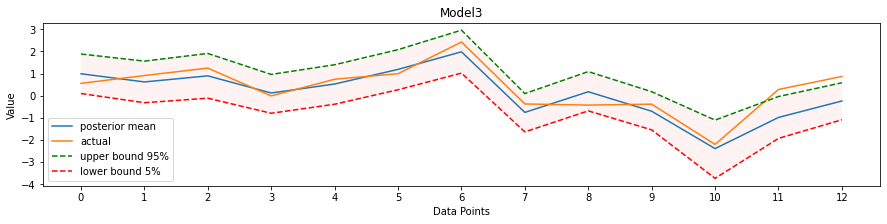

<Figure size 432x288 with 0 Axes>

In [160]:
plot_forecast(taskModel3,'Model3')

In [161]:
print(accuracy(taskModel1))
print(accuracy(taskModel2))
print(accuracy(taskModel3))

MAPE: 0.52%
MAPE: 0.48%
MAPE: 0.46%
